<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Метрика.-Описание" data-toc-modified-id="Метрика.-Описание-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Метрика. Описание</a></span></li><li><span><a href="#Распознавание-таблиц" data-toc-modified-id="Распознавание-таблиц-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Распознавание таблиц</a></span><ul class="toc-item"><li><span><a href="#Модель-NANONETSOCR" data-toc-modified-id="Модель-NANONETSOCR-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Модель NANONETSOCR</a></span><ul class="toc-item"><li><span><a href="#Установка-модели.-Пример-работы" data-toc-modified-id="Установка-модели.-Пример-работы-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Установка модели. Пример работы</a></span></li><li><span><a href="#Преобразование-распознанных-данных" data-toc-modified-id="Преобразование-распознанных-данных-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Преобразование распознанных данных</a></span></li><li><span><a href="#Тестирование-на-всех-данных" data-toc-modified-id="Тестирование-на-всех-данных-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Тестирование на всех данных</a></span></li></ul></li></ul></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></div>

# **Распознавание таблиц медицинских справок для DonorSearch**
**Заказчик:** Сообщество доноров Крови "DonorSearch"

**Цель:** Автоматизировать перенос данных с фотографий медицинских справок донора в формат .csv.

**Задача:** Детектировать табличную часть справки, распознать текст и привести данные к требуемому шаблону.

**Модель:** В работе использовали Модель-NANONETSOCR

**Метрика:** Accuracy



### **Описание данных:**
- **Исходные данные:**
  - 16 фотографий медицинских справок с данными от доноров (унифицированная форма №405) для распознавания,
  - 15 файлов с соответствующей инфрормцацией в формате .csv (для провыерки качества рабоы нашей модели)
- **Терминология** для итоговой распознанной таблицы:
  - **Класс крови:** Цельная кровь, Плазма, Тромбоциты.
  - **Тип донации:** Безвозмездно.

### **Описание проекта**
Для реализации задачи:
- использована **модель NANONETSOCR**.
- сформирована функция для обработки распознаннаых данных и преобразования в необходимы формат;
- проведены исследования качества нашей модели.

## **Импорт библиотек**

In [117]:
#!pip install opencv-python -q

In [ ]:
# Открытие пользовательского файла

root=Tk()
# Button(root, text='File Open', command = openFile).pack(fill=X)

root.geometry('400x400')
root.file_name=filedialog.askopenfilename(initialdir="your directory path", title="file uploader",
                               filetypes=(("jpg files", "*.jpg"), ("all files", "*.*")))
    # takes path that is selected by dialog box
img =Image.open(root.file_name)
root.update()   
root.destroy() 

# image

from tkinter import *
from tkinter import Tk,filedialog,Button,Label
from PIL import ImageTk,Image
import sys
from tkinter.filedialog import askopenfilename

In [118]:
import pandas as pd
import cv2
import os
import re
from re import search
import time
from os import listdir
from datetime import datetime

from PIL import Image as PImage

import numpy as np
import matplotlib.pyplot as plt

In [119]:
#если данные храняться на googledisk, подключаем его
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Обзор данных**

In [120]:
try:
    t=pd.read_csv('data/405/target/141899.csv')
except:
    t=pd.read_csv('/content/drive/MyDrive/donor/405/csv/141899.csv')
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       29 non-null     int64 
 1   ID пользователя          29 non-null     int64 
 2   Класс крови              29 non-null     object
 3   Дата донации             29 non-null     object
 4   Дата добавления донации  29 non-null     object
 5   Тип донации              29 non-null     object
 6   Регион                   29 non-null     object
 7   Место стадчи             29 non-null     int64 
 8   Статус донации           29 non-null     object
 9   Есть справка             29 non-null     object
dtypes: int64(3), object(7)
memory usage: 2.4+ KB


In [121]:
try:
    t=pd.read_csv('data/405/target/204119.csv')
except:
    t=pd.read_csv('/content/drive/MyDrive/donor/405/csv/204119.csv')
t.head(14)

ID  ID пользователя    Класс крови Дата донации  \
0  170415           204119  Цельная кровь   01.04.2015   
1  170430           204119  Цельная кровь   27.07.2017   
2  170431           204119  Цельная кровь   11.10.2017   
3  170432           204119  Цельная кровь   30.07.2018   
4  170433           204119  Цельная кровь   16.10.2018   
5  170434           204119  Цельная кровь   15.10.2019   

  Дата добавления донации   Тип донации                             Регион  \
0              23.12.2022  Безвозмездно     Россия, Тульская область, Тула   
1              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   
2              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   
3              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   
4              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   
5              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   

     Место стадчи Статус донации Есть справка  
0             556        Принята           Да  
1  Выездная акция        Принята           Да  
2  Выездная акция        Принята           Да  
3  Выездная акция        Принята           Да  
4  Выездная акция        Принята           Да  
5  Выездная акция        Принята           Да

In [122]:
try:
    img = PImage.open('C:/Users/zoika/OneDrive/Рабочий стол/YP ds54/Practika/OCR_Donor_search/data/405/scan/141899 .jpg')
except:
    img = PImage.open('/content/drive/MyDrive/donor/405/scan/141899 .jpg')
#img

In [123]:
df_info = { 'Дано на фото:  Вид дон-ва': ['кр / д ( бв )', 'пл / д ( бв ), пп / д ( бв ), п / ф ( бв )', 'т / ф ( бв ), ц / д ( бв )'],
          'Должны получить в csv: Класс крови': ['Цельная кровь', 'Плазма', 'Тромбоциты'],
           'Тип донации': ['Безвозмездно', 'Безвозмездно', 'Безвозмездно'] }
df_info = pd.DataFrame(df_info)
df_info

Дано на фото:  Вид дон-ва  \
0                               кр / д ( бв )   
1  пл / д ( бв ), пп / д ( бв ), п / ф ( бв )   
2                  т / ф ( бв ), ц / д ( бв )   

  Должны получить в csv: Класс крови   Тип донации  
0                      Цельная кровь  Безвозмездно  
1                             Плазма  Безвозмездно  
2                         Тромбоциты  Безвозмездно

**Выводы:**
- Мы видим, что нам необходимо заполнить с картинки не все колонки, а только:
  - 'Класс крови',
  - 'Дата донации',
  - 'Тип донации'.
- Пропусков не обнаружено.
- Необходима предобработка данных:
- Соотнесены возможные сокращения:

Учтем все это в дальнейшей работе

## **Загрузка данных**

Чтобы было удобно прогонять сразу все данные через модель и оценивать качество распознавания - объединим все картинки и соответствующие им таргеты (файлы .csv) в одном датафрейме.
Для этого:
- Напишем функцию, которая принимает на вход путь с расположением картинок и путь с расположением целевых таблиц.
> На выходе будет датафрейм, сопоставляющий для каждой картинки:
 - имя объекта,
 - путь для каждой картинки (необходимо для библиотки нанонетс),
 - саму картинку,
 - соответствующий ей таргет (файл csv).

- Внутри функции, из csv-файлов будут удалены лишние столбцы, которые нет необходимости заполнять на основании картинки.

In [124]:
try:
    #если данные храняться на googleDisk
    path = '/content/drive/MyDrive/donor/405/scan/'
    path_csv = '/content/drive/MyDrive/donor/405/csv/'
except:
    path='data/405/scan/'  #если данные на локалке (здесь картинки в отдельной папке scan, ноут в одной папке с data...)
    path_csv='data/405/target/'
#path[1]

In [125]:
def loadImages(path,path_csv):

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:

        img = PImage.open(path + image)
        path_jpg=path + image
        #img=np.array(img)/255

        name=str(image)
        name=name.split(' ')[0]
        name=re.sub(r'(.jpg)', '', name)

        target=pd.read_csv(path_csv + name + '.csv')
        target=target[['Класс крови','Дата донации','Тип донации']] #,'Регион','Место стадчи'
        target['Дата донации']=pd.to_datetime(target['Дата донации'], format='%d.%m.%Y',errors='coerce')


        list=[name,img,path_jpg,target]
        loadedImages.append(list)

        df=pd.DataFrame(loadedImages, columns = ['name','input_image','path_jpg','target_csv'])
        df=df.set_index('name')

    return df

df = loadImages(path,path_csv)
df.head(3)

input_image  \
name                                                        
141899  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
225629  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
231820  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                 path_jpg  \
name                                                        
141899  /content/drive/MyDrive/donor/405/scan/141899 .jpg   
225629  /content/drive/MyDrive/donor/405/scan/225629 .jpg   
231820  /content/drive/MyDrive/donor/405/scan/231820 .jpg   

                                               target_csv  
name                                                       
141899        Класс крови Дата донации   Тип донации
0...  
225629        Класс крови Дата донации   Тип донации
0...  
231820        Класс крови Дата донации   Тип донации
0...

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 141899 to 245365
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input_image  15 non-null     object
 1   path_jpg     15 non-null     object
 2   target_csv   15 non-null     object
dtypes: object(3)
memory usage: 480.0+ bytes


In [127]:
df['target_csv']['204119'].info()  #обращение к целевой таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Класс крови   6 non-null      object        
 1   Дата донации  6 non-null      datetime64[ns]
 2   Тип донации   6 non-null      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 272.0+ bytes


**Вывод:**
- Загрузили и сопоставили все, имеющиеся данные:
  - необходимо заполнить с картинки не все колонки, а только: **'Класс крови'**, **'Дата донации'**, **'Тип донации'**.
- Проверили, что все 15 изображений на месте.
- Пропусков, нулей - нет.
- Соотнесены возможные сокращения:
 > **Класс крови:**
  - Цельная кровь = [кр / д]
  - Плазма = [пл / д, пп / д, п / ф]
  - Тромбоциты = [т / ф, ц / д]

 > **Тип донации:**
  -  Безвозмездно = [( бв )]

- Необходима предобработка данных:
  - Даты необходимо привести к единому формату чч.мм.гггг,
  - Есть несоответствие в названиях и то, что значение одной колонки на картинке, в целевой табличке разбито на две.
  - наблюдаются "шумы".

Учтем все это в дальнейшей работе

## **Метрика. Описание**
Чтобы можно было оценивать и сравнивать различные модели или их модификации - нужна метрика.
Поэтому напишем функцию, которая будет считать аналог **Accuracy** для таблиц.
 > А именно, считать и выводить - долю, правильно распознанных ячеек.

In [128]:
def metric_acc(df_pred,df_target):
    count=0
    count_good=0
    for j in range(df_target.shape[1]):
        for i in range(df_target.shape[0]):
            try:
                if df_target.iloc[i,j]==df_pred.iloc[i,j]:
                    count_good+=1
                    count+=1
                else: count+=1
            except:count+=1
    #print('Всего ячеек:',count,'. Верных:',count_good, '. Acc:',count_good/count)
    acc=count_good/count
    return count, count_good, acc

## Распознавание таблиц

**Гипотеза №1:** с помощью библиотеки NANONETSOCR удастся распознать не менее 70% табличных данных:
> Рабочая область столбцы: 'Класс крови','Дата донации','Тип донации'

###  **Модель NANONETSOCR**
Данная модель способна сразу выделить на изображении таблицу и распознать ее.

Загрузка библиотек и самой модели:

####  **Установка модели. Пример работы**

In [129]:
!pip install ocr-nanonets-wrapper -q

In [130]:
try:
    key=pd.read_csv('/key.csv')
except:
    key=pd.read_csv('/content/drive/MyDrive/donor/405/key.csv')
key['key'][0]

'fc72708f-15f0-11ee-98fc-42d8be35afd1'

In [131]:
from nanonets import NANONETSOCR
model = NANONETSOCR()
model.set_token(key['key'][0]) #ключ генерируется в личном кабинете на сайте https://nanonets.com

Проверим работу модели на примере произвольной картинки.
Картинка:

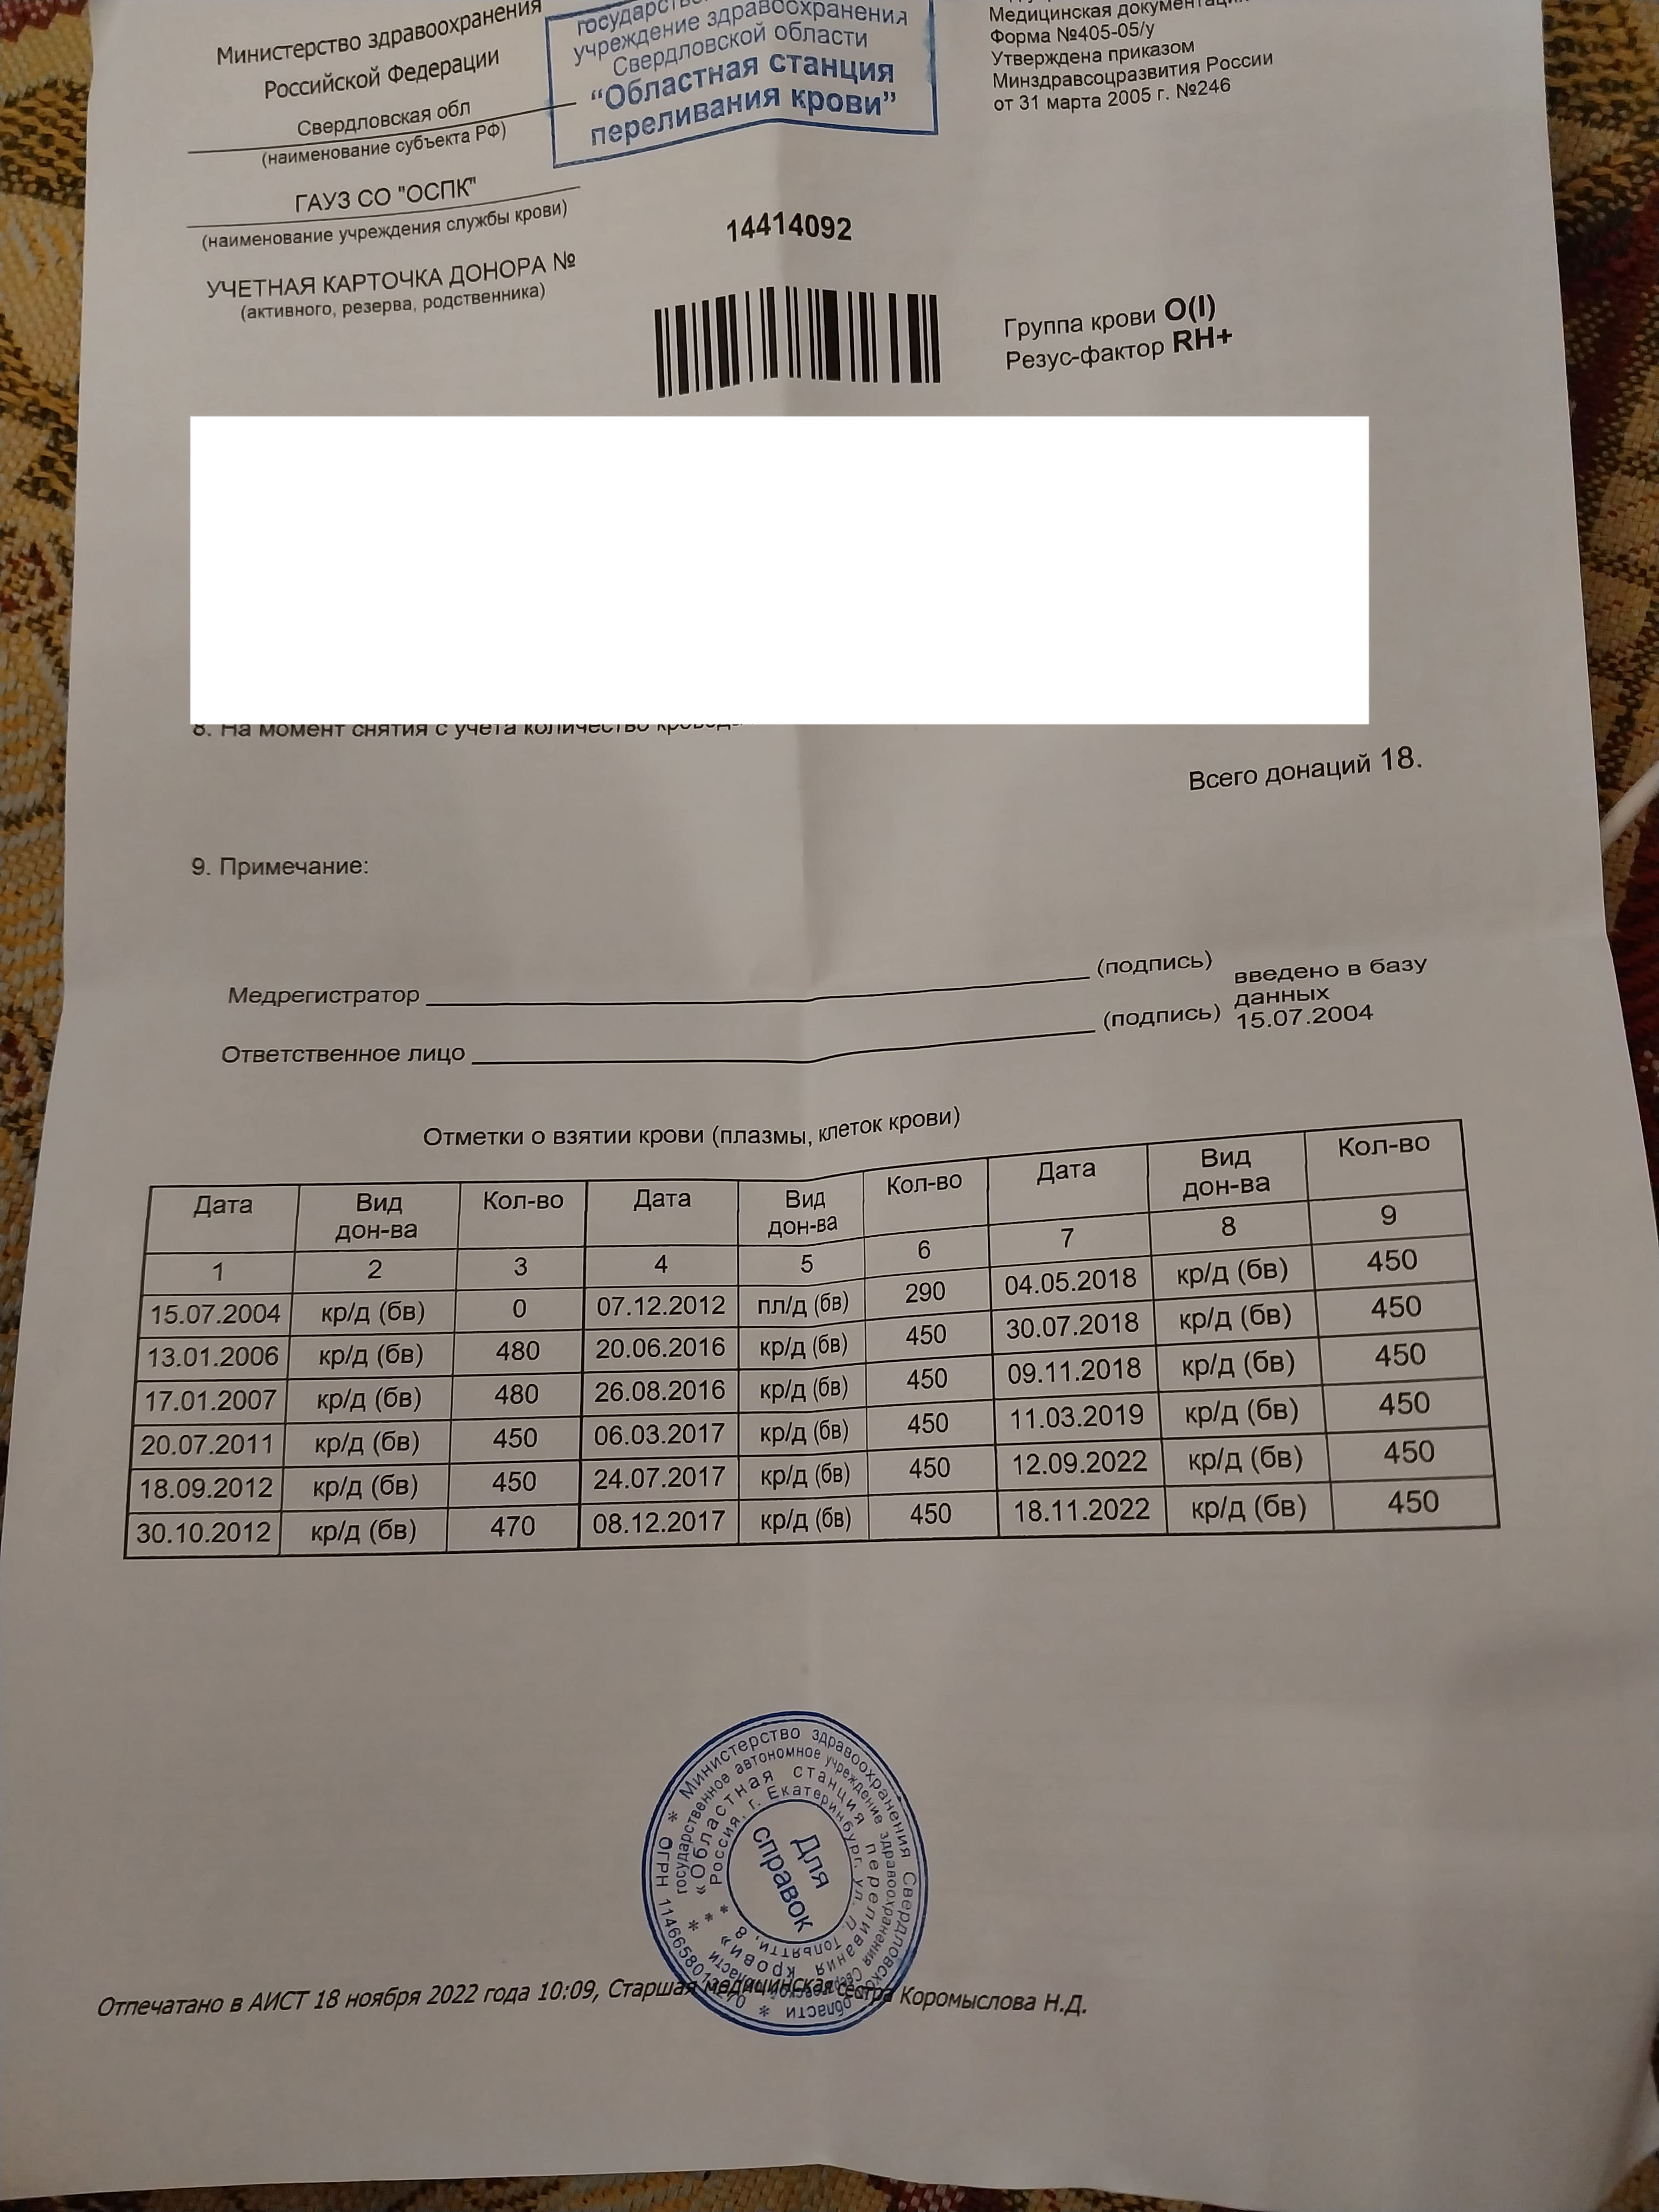

In [132]:
num_img_test='225629' #выберем произвольный номер картинки (строки в дф)
df['input_image'][num_img_test]

Используем метод **convert_to_csv** для данной картинки и выведем результат:

In [133]:
%%time
model.convert_to_csv(df['path_jpg'][num_img_test],output_file_name='OUTPUTFILE.csv')
test_NANO=pd.read_csv('OUTPUTFILE.csv')
test_NANO

CPU times: user 171 ms, sys: 11.1 ms, total: 183 ms
Wall time: 25.3 s


Unnamed: 0     Unnamed: 1 Unnamed: 2    Unnamed: 3     Unnamed: 4  \
0     TABLE 1            NaN        NaN           NaN            NaN   
1         NaN            NaN        NaN           NaN            NaN   
2        Дата  Вид\nдон - ва   Кол - во          Дата  Вид\nдон - ва   
3           1              2          3             4              5   
4  15.07.2004  кр / д ( бв )          0    07.12.2012  Пл / д ( бв )   
5  13.01.2006  кр / д ( бв )        480  20.06.2016 |  кр / д ( бв )   
6  17.01.2007  кр / д ( бв )        480    26.08.2016  Кр / д ( бв )   
7  20.07.2011  кр / д ( бв )        450  06.03.2017 |  кр / д ( бв )   
8  18.09.2012  кр / д ( бв )        450  24.07.2017 |  кр / д ( бв )   
9  30.10.2012  кр / д ( бв )        470  08.12.2017 |  кр / д ( бв )   

  Unnamed: 5  Unnamed: 6        Unnamed: 7   Unnamed: 8  
0        NaN         NaN               NaN          NaN  
1        NaN         NaN               NaN          NaN  
2   Кол - во        Дата  Вид\nдон - ва\n8  Кол - во\n9  
3          6           7               NaN          450  
4        290  04.05.2018     кр / д ( бв )          450  
5        450  30.07.2018     кр / д ( бв )          450  
6        450  09.11.2018     кр / д ( бв )          450  
7        450  11.03.2019     кр / д ( бв )          450  
8        450  12.09.2022     кр / д ( бв )          450  
9        450  18.11.2022     кр / д ( бв )          450

**Вывод:**

- Даже на примере размытой картинки мы видим, что модель смогла выделить таблицу и верно оперделить больше половины числовых значений.

- Однако, много лишней информации и последовательность колонок отличается от целевой.

- Чтобы это исправить и привести данные как можно ближе к требованиям заказчика, напишем специальную функцию в следующем пункте.

####  **Преобразование распознанных данных**

In [134]:
#функция преобразования исходных данных в необходимый формат
def df_transform(df):

# Чистка таблицы ---------------------------------------------------------
    df = df.applymap(lambda cell: cell.lower() if isinstance(cell, str) else cell)
    df = df.applymap(lambda cell: cell.replace(' ', '') if isinstance(cell, str) else cell)
    df = df.applymap(lambda cell: cell.replace('|', '') if isinstance(cell, str) else cell)

# Создадим новый дф перенесем в него данные в нужном порядке   --------------------------------------------------

    df_new=pd.DataFrame(columns=['Класс крови','Дата донации','Тип донации','Кол-во']) #,'Регион','Место стадчи'

    i_new=0

    for j in range(df.shape[1]):
        for i in range(df.shape[0]):

            if (df.iloc[i,j]=='дата') or (df.iloc[i,j]=='dara'):  # Доработать/  содержит д/d/ ата
                for i in range(i,df.shape[0]-2):

                    stroka_df_new=[]

               # Класс крови-------------------------------------

                    massiv  = '(?:{})'.format('|'.join(['k','ka','кр','к'])) #'Цельная кровь'
                    massiv1 = '(?:{})'.format('|'.join(['т / ф', 'ц / д','т/ф', 'ц/д','t / ф'])) #тромбоциты
                    massiv2 = '(?:{})'.format('|'.join(['пл/д', 'пл/ д','пл / д', 'пл /д','п / ф' \
                                                        ,'п/ф','п /ф','п/ ф','пп/д','пп / д'])) #Плазма

                    if  search(massiv, str(df.iloc[i+2,j+1])):
                        stroka_df_new.append('Цельная кровь')
                    elif search(massiv1, str(df.iloc[i+2,j+1])):
                        stroka_df_new.append('Тромбоциты')
                    elif search(massiv2, str(df.iloc[i+2,j+1])):
                        stroka_df_new.append('Плазма')
                    else:stroka_df_new.append('unknown')

              #  Дата донации-------------------------------------

                    try:
                        data_new=pd.to_datetime(df.iloc[i+2,j], format='%d.%m.%y').strftime('%d.%m.%Y')
                        stroka_df_new.append(data_new)
                    except:

                        try:
                            data_new=pd.to_datetime(df.iloc[i+2,j], format='%d.%m.%Y').strftime('%d.%m.%Y')
                            stroka_df_new.append(data_new)
                        except:
                            stroka_df_new.append('unknown')

             # Тип донации----------------------------------------
                  #  massiv_bv  = '(?:{})'.format('|'.join(['bB','бB','бв','бп','ба','68','бe','бе'])) #'Безвозмездно' 'Бв','БВ','бВ',

                    if search('плат',str(df.iloc[i+2,j+1])):
                        stroka_df_new.append('Платно')


                    else:
                        stroka_df_new.append('Безвозмездно')

             #---------------------------------------------------------

                   # stroka_df_new.append('unknown')           # 'Регион'
                   # stroka_df_new.append('unknown')           # 'Место стадчи'
                    stroka_df_new.append(df.iloc[i+2,j+2])    # Kol-vo

                    df_new.loc[i_new]=stroka_df_new
                    i_new+=1


    for i in range(df_new.shape[0]):
        if (df_new['Класс крови'][i]=='unknown') and (df_new['Дата донации'][i]=='unknown'):
            df_new=df_new.drop([i])
    try:
        df_new['Дата донации']=pd.to_datetime(df_new['Дата донации'],format="%d.%m.%Y",errors='coerce')
        df_new=df_new.sort_values('Дата донации')

    except:
        print('Не получилось отсортировать дату')

    return df_new

In [135]:
test_NANO

Unnamed: 0     Unnamed: 1 Unnamed: 2    Unnamed: 3     Unnamed: 4  \
0     TABLE 1            NaN        NaN           NaN            NaN   
1         NaN            NaN        NaN           NaN            NaN   
2        Дата  Вид\nдон - ва   Кол - во          Дата  Вид\nдон - ва   
3           1              2          3             4              5   
4  15.07.2004  кр / д ( бв )          0    07.12.2012  Пл / д ( бв )   
5  13.01.2006  кр / д ( бв )        480  20.06.2016 |  кр / д ( бв )   
6  17.01.2007  кр / д ( бв )        480    26.08.2016  Кр / д ( бв )   
7  20.07.2011  кр / д ( бв )        450  06.03.2017 |  кр / д ( бв )   
8  18.09.2012  кр / д ( бв )        450  24.07.2017 |  кр / д ( бв )   
9  30.10.2012  кр / д ( бв )        470  08.12.2017 |  кр / д ( бв )   

  Unnamed: 5  Unnamed: 6        Unnamed: 7   Unnamed: 8  
0        NaN         NaN               NaN          NaN  
1        NaN         NaN               NaN          NaN  
2   Кол - во        Дата  Вид\nдон - ва\n8  Кол - во\n9  
3          6           7               NaN          450  
4        290  04.05.2018     кр / д ( бв )          450  
5        450  30.07.2018     кр / д ( бв )          450  
6        450  09.11.2018     кр / д ( бв )          450  
7        450  11.03.2019     кр / д ( бв )          450  
8        450  12.09.2022     кр / д ( бв )          450  
9        450  18.11.2022     кр / д ( бв )          450

In [136]:
df_test=df_transform(test_NANO)
df_test

Класс крови Дата донации   Тип донации Кол-во
0   Цельная кровь   2004-07-15  Безвозмездно      0
1   Цельная кровь   2006-01-13  Безвозмездно    480
2   Цельная кровь   2007-01-17  Безвозмездно    480
3   Цельная кровь   2011-07-20  Безвозмездно    450
4   Цельная кровь   2012-09-18  Безвозмездно    450
5   Цельная кровь   2012-10-30  Безвозмездно    470
6          Плазма   2012-12-07  Безвозмездно    290
7   Цельная кровь   2016-06-20  Безвозмездно    450
8   Цельная кровь   2016-08-26  Безвозмездно    450
9   Цельная кровь   2017-03-06  Безвозмездно    450
10  Цельная кровь   2017-07-24  Безвозмездно    450
11  Цельная кровь   2017-12-08  Безвозмездно    450
12  Цельная кровь   2018-05-04  Безвозмездно    450
13  Цельная кровь   2018-07-30  Безвозмездно    450
14  Цельная кровь   2018-11-09  Безвозмездно    450
15  Цельная кровь   2019-03-11  Безвозмездно    450
16  Цельная кровь   2022-09-12  Безвозмездно    450
17  Цельная кровь   2022-11-18  Безвозмездно    450

In [137]:
df_test['Дата донации']=pd.to_datetime(df_test['Дата донации'],format="%d.%m.%Y",errors='coerce')#.strftime('%d.%m.%Y')

In [138]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Класс крови   18 non-null     object        
 1   Дата донации  18 non-null     datetime64[ns]
 2   Тип донации   18 non-null     object        
 3   Кол-во        18 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 720.0+ bytes


In [139]:
df_test

Класс крови Дата донации   Тип донации Кол-во
0   Цельная кровь   2004-07-15  Безвозмездно      0
1   Цельная кровь   2006-01-13  Безвозмездно    480
2   Цельная кровь   2007-01-17  Безвозмездно    480
3   Цельная кровь   2011-07-20  Безвозмездно    450
4   Цельная кровь   2012-09-18  Безвозмездно    450
5   Цельная кровь   2012-10-30  Безвозмездно    470
6          Плазма   2012-12-07  Безвозмездно    290
7   Цельная кровь   2016-06-20  Безвозмездно    450
8   Цельная кровь   2016-08-26  Безвозмездно    450
9   Цельная кровь   2017-03-06  Безвозмездно    450
10  Цельная кровь   2017-07-24  Безвозмездно    450
11  Цельная кровь   2017-12-08  Безвозмездно    450
12  Цельная кровь   2018-05-04  Безвозмездно    450
13  Цельная кровь   2018-07-30  Безвозмездно    450
14  Цельная кровь   2018-11-09  Безвозмездно    450
15  Цельная кровь   2019-03-11  Безвозмездно    450
16  Цельная кровь   2022-09-12  Безвозмездно    450
17  Цельная кровь   2022-11-18  Безвозмездно    450

In [140]:
#Проверка метрики
metric_acc(df_test,df['target_csv'][num_img_test])

(54, 54, 1.0)

In [141]:
df['target_csv'][num_img_test]

Класс крови Дата донации   Тип донации
0   Цельная кровь   2004-07-15  Безвозмездно
1   Цельная кровь   2006-01-13  Безвозмездно
2   Цельная кровь   2007-01-17  Безвозмездно
3   Цельная кровь   2011-07-20  Безвозмездно
4   Цельная кровь   2012-09-18  Безвозмездно
5   Цельная кровь   2012-10-30  Безвозмездно
6          Плазма   2012-12-07  Безвозмездно
7   Цельная кровь   2016-06-20  Безвозмездно
8   Цельная кровь   2016-08-26  Безвозмездно
9   Цельная кровь   2017-03-06  Безвозмездно
10  Цельная кровь   2017-07-24  Безвозмездно
11  Цельная кровь   2017-12-08  Безвозмездно
12  Цельная кровь   2018-05-04  Безвозмездно
13  Цельная кровь   2018-07-30  Безвозмездно
14  Цельная кровь   2018-11-09  Безвозмездно
15  Цельная кровь   2019-03-11  Безвозмездно
16  Цельная кровь   2022-09-12  Безвозмездно
17  Цельная кровь   2022-11-18  Безвозмездно

####  **Тестирование на всех данных**

In [142]:
def acc_all_nano(df):
    acc_list=[]
    for i, row in df.iterrows():
        print('file_name:',i)
        model.convert_to_csv(row['path_jpg'],output_file_name='OUTPUTFILE_for_metric.csv')
        nano_table=pd.read_csv('OUTPUTFILE_for_metric.csv')
        new_nano_table=df_transform(nano_table)
        acc=metric_acc(new_nano_table,row['target_csv'])
        acc_list.append(acc)
    print('Метрика, усредненная:',sum(acc_list)/len(acc_list))
    return sum(acc_list)/len(acc_list)

In [143]:
%%time
def acc_all_nano(df):
    count_list = []
    count_good_list = []
    acc_list = []
    file_name = []
    for i, row in df.iterrows():
        #print('file_name:',i)
        model.convert_to_csv(row['path_jpg'],output_file_name='OUTPUTFILE_for_metric.csv')
        nano_table=pd.read_csv('OUTPUTFILE_for_metric.csv')
        new_nano_table=df_transform(nano_table)
        count, count_good, acc=metric_acc(new_nano_table,row['target_csv'])
        acc_list.append(acc)
        file_name.append(i)
        count_good_list.append(count_good)
        count_list.append(count)
    accuracy_mean = sum(acc_list)/len(acc_list)
    #print('Метрика, усредненная:',accuracy_mean)
    return acc_list, file_name, accuracy_mean, count_good_list, count_list

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11.9 µs


In [144]:
#функция формирования итоговой таблицы с данными по качеству работы модели
def acc_table(acc_list, file_name, accuracy_mean, count_good_list, count_list):
    data = {'Название файла': file_name, 'Число ячеек': count_list,
        'Число верных ячеек': count_good_list, 'Accuracy': [round(acc, 3) for acc in acc_list]}
    acc_table = pd.DataFrame(data)
    acc_table['Число ячеек'] = acc_table['Число ячеек'].astype(int).astype(object)
    acc_table['Число верных ячеек'] = acc_table['Число верных ячеек'].astype(int).astype(object)
    mean_row = {'Название файла': 'Общая точность', 'Число ячеек': '-', 'Число верных ячеек': '-', 'Accuracy': round(accuracy_mean, 3)}
    acc_table = acc_table.append(mean_row, ignore_index=True)
    return acc_table

In [145]:
%%time
acc_list, file_name, accuracy_mean, count_good_list, count_list = acc_all_nano(df)
acc_table = acc_table(acc_list, file_name, accuracy_mean, count_good_list, count_list)
acc_table

CPU times: user 2.52 s, sys: 201 ms, total: 2.72 s
Wall time: 4min 10s


Название файла Число ячеек Число верных ячеек  Accuracy
0           141899          87                 35     0.402
1           225629          54                 54     1.000
2           231820          39                 39     1.000
3           228963          69                 24     0.348
4           213950          66                 66     1.000
5           236000          15                 15     1.000
6           227414          60                 52     0.867
7           204119          18                 18     1.000
8           233749          63                 63     1.000
9           256578          30                  0     0.000
10          256838          66                 24     0.364
11          254586          33                 31     0.939
12          243478         114                 47     0.412
13          238716         108                108     1.000
14          245365         111                111     1.000
15  Общая точность           -                  -     0.755

## **Вывод:**
Для реализации задачи использована **модель NANONETSOCR**.
- Проведено исследование данных. Осуществили соотнесение входящих данных с необходимым итоговым результатом:
  - Определены сокращения и соотнесены с используемой терминологией:
      - Цельная кровь = [кр / д]
      - Плазма = [пл / д, пп / д, п / ф]
      - Тромбоциты = [т / ф, ц / д]
      - Тип донации: Безвозмездно = [( бв )]
  - Определили необходимые дальнейшие преобразования для дальнейшей работы модели и оценки качества модели.
- Проведено исследование модели **NANONETSOCR**,
- Разработана функция постобработки распознанных данных - распознанная таблица приводится в соответствующий формат.
  - Фрмируются рабочие колонки: 'Класс крови', 'Дата донации', 'Тип донации',
  - Все возможные сокращения преобразовываются в используемую терминологию необходимого итогового результата.
  - Дата донации: переводится в формат чч.мм.гггг,
  - Проводится очиства от лишних "шумов".
- Сформирована функция оценки качества распознавания табличных данных - наналог **Accuracy**.
- Проведена оценка работоспособности полученного алгоритма, метрика **Accuracy**:
  - С помощью доработоной модели удалось получить общее **качество распознавания более 75,5%**.
Таким образом, гипотеза №1 - подтвердилась.
  - Время полного цикла преобразований одного изображения занимает от 10 до 30 секунд.

Также наша модель хорошо распознает колонку "Количество", однако, ее нет в целевых таблицах, поэтому в расчет метрики ее не включили, но, если заказчику понадобится в будущем, эта клонка, то ее легко можно добавить.